# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000L, 3073L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3073L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3073L)
Test labels shape:  (1000L,)
dev data shape:  (500L, 3073L)
dev labels shape:  (500L,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
test = np.random.randn(500,10)
sums = np.sum(test,axis=1)
print sums.shape
np.sum(test)
num_train = test.shape[0]
print num_train

(500L,)
500


In [4]:
test -= np.max(test)
np.max(test)

0.0

In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.387746
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.328598 analytic: 0.328598, relative error: 6.160607e-08
numerical: 0.171848 analytic: 0.171848, relative error: 2.001577e-09
numerical: 0.260340 analytic: 0.260340, relative error: 1.629737e-07
numerical: -0.540202 analytic: -0.540202, relative error: 5.291942e-08
numerical: -1.038466 analytic: -1.038466, relative error: 7.126983e-08
numerical: -0.747241 analytic: -0.747241, relative error: 3.725697e-08
numerical: 0.747905 analytic: 0.747905, relative error: 5.654743e-08
numerical: 0.193628 analytic: 0.193628, relative error: 8.598002e-08
numerical: 0.852452 analytic: 0.852452, relative error: 7.536556e-08
numerical: -0.571055 analytic: -0.571055, relative error: 4.553142e-08
numerical: 0.742499 analytic: 0.742499, relative error: 4.644030e-08
numerical: -1.030728 analytic: -1.030728, relative error: 6.502132e-08
numerical: -1.368978 analytic: -1.368978, relative error: 2.456224e-09
numerical: 0.030869 analytic: 0.030869, relative error: 5.021270e-07
numerical: -5.618527 a

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.387746e+00 computed in 0.009000s
vectorized loss: 2.387746e+00 computed in 0.009000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [76]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = 10**np.random.uniform(-8,-5,4)
regularization_strengths = 10**np.random.uniform(3, 5,4)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
samples = 15
#for lr in learning_rates:
#    for reg in regularization_strengths:
for i in range(samples):
        lr = 10**np.random.uniform(-7,-5)
        reg = 10**np.random.uniform(3, 4)
        softmax= Softmax()
        _ = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=500, verbose=False)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        results[(lr,reg)] = (acc_train,acc_val)
        print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, acc_train, acc_val)
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax
            best_lr = lr
            best_reg = reg
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
#for lr, reg in sorted(results):
#    train_accuracy, val_accuracy = results[(lr, reg)]
#    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
print 'best lr is %s , best reg is %s' %(best_lr,best_reg)

lr 3.075350e-07 reg 1.498194e+03 train accuracy: 0.262204 val accuracy: 0.278000
lr 8.448154e-07 reg 1.791410e+03 train accuracy: 0.337061 val accuracy: 0.360000
lr 1.912484e-06 reg 8.015091e+03 train accuracy: 0.355469 val accuracy: 0.368000
lr 3.558019e-06 reg 1.040601e+03 train accuracy: 0.390735 val accuracy: 0.404000
lr 1.476696e-07 reg 1.656631e+03 train accuracy: 0.222245 val accuracy: 0.218000
lr 1.807561e-07 reg 2.467175e+03 train accuracy: 0.240184 val accuracy: 0.260000
lr 3.835896e-06 reg 9.895327e+03 train accuracy: 0.350735 val accuracy: 0.346000
lr 5.536842e-06 reg 7.806797e+03 train accuracy: 0.302959 val accuracy: 0.314000
lr 2.107712e-06 reg 9.555033e+03 train accuracy: 0.346755 val accuracy: 0.346000
lr 3.191836e-07 reg 1.231913e+03 train accuracy: 0.262939 val accuracy: 0.273000
lr 9.022258e-06 reg 3.178208e+03 train accuracy: 0.260571 val accuracy: 0.276000
lr 1.447203e-06 reg 8.012951e+03 train accuracy: 0.371408 val accuracy: 0.369000
lr 1.671771e-06 reg 5.598985

In [77]:
from hyperparam_plot import hyperparam_plot
from hyperparam_plot import poly_contour_plot


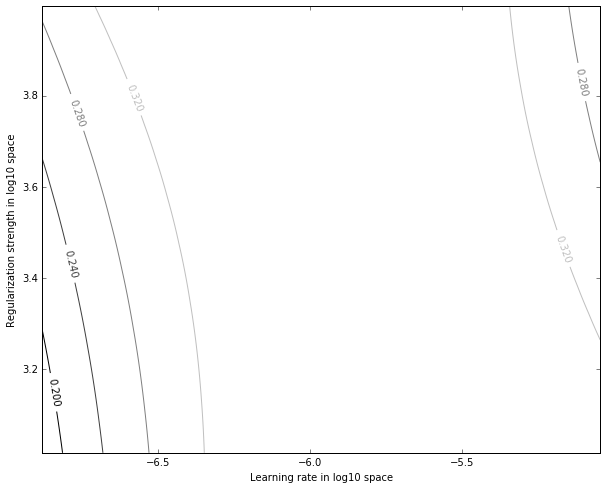

In [78]:
poly_contour_plot(results)

In [56]:
test = np.ones(500)
test.shape

(500L,)

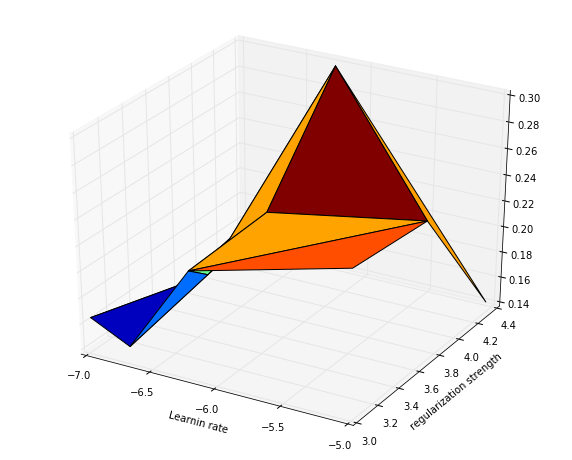

In [87]:
hyperparam_plot(results)

In [82]:
test = np.random.random((5,3))
print test
mean = np.mean(test,axis=0)
print mean
var = np.var(test,axis=0)
print var
test = (test-mean)/var
print test


[[ 0.08106249  0.59476778  0.63664402]
 [ 0.3887925   0.54111797  0.3427812 ]
 [ 0.00433827  0.69180761  0.49601885]
 [ 0.35875112  0.19493508  0.10351578]
 [ 0.53709323  0.32766597  0.84497008]]
[ 0.27400752  0.47005888  0.48478598]
[ 0.03990409  0.03314861  0.06369039]
[[-4.83521943  3.76211539  2.38431629]
 [ 2.87652156  2.14365222 -2.22961087]
 [-6.75793517  6.68953336  0.17636668]
 [ 2.12368199 -8.29970856 -5.98630666]
 [ 6.59295105 -4.29559241  5.65523456]]


In [42]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.285000


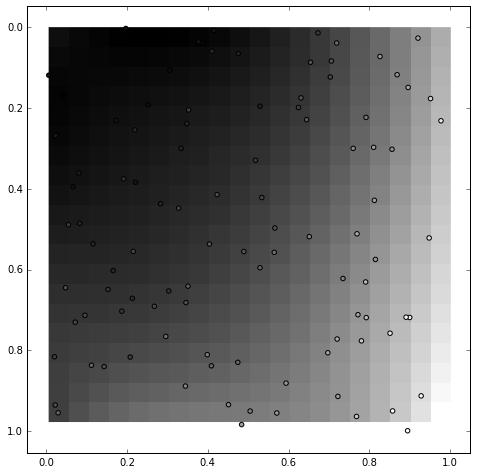

In [19]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Generate Data...
    numdata = 100
    x = np.random.random(numdata)
    y = np.random.random(numdata)
    z = x**2 + y**2 + 3*x**3 + y + np.random.random(numdata)

    # Fit a 3rd order, 2d polynomial
    m = polyfit2d(x,y,z)

    # Evaluate it on a grid...
    nx, ny = 20, 20
    xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx), 
                         np.linspace(y.min(), y.max(), ny))
    zz = polyval2d(xx, yy, m)

    # Plot
    plt.imshow(zz, extent=(x.min(), y.max(), x.max(), y.min()))
    plt.scatter(x, y, c=z)
    plt.show()

def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

main()

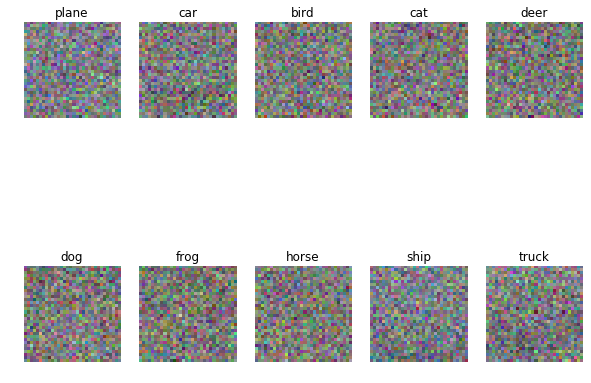

In [43]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])